### Libraries

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os 
import tqdm
import glob
import tensorflow 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.data.experimental import AUTOTUNE
from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras.layers import RandomRotation, RandomZoom
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras import applications
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam


from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow
from skimage.transform import resize

from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Precision, AUC,Recall
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet169
import copy
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import cv2
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.applications.vgg19 import VGG19,preprocess_input
from tensorflow.keras.utils import image_dataset_from_directory
from keras.utils import plot_model


In [27]:
!pip install visualkeras
!pip install ann_visualizer
!pip install graphviz

In [28]:
!pip install git+https://github.com/jfilter/split-folders.git


  Cloning https://github.com/jfilter/split-folders.git to /tmp/pip-req-build-uqcrzzvv
  Running command git clone --filter=blob:none --quiet https://github.com/jfilter/split-folders.git /tmp/pip-req-build-uqcrzzvv
  Resolved https://github.com/jfilter/split-folders.git to commit c566dbd56a1097e1ddba2de5dfb93bd67eade54f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# **Data Preprocessing**

In [29]:
import splitfolders

# Set the path of the directory containing the original images
input_folder = '/kaggle/input/alzheimer-mri-dataset/Dataset'

# Set the base directory for the split images
output_folder = '/kaggle/working/Splitted'

# Set the ratio of images for each split
train_ratio = 0.8
validation_ratio = 0.1
test_ratio = 0.1

# Use the splitfolders library to split the images into train-validation-test sets
splitfolders.ratio(input_folder, output_folder, seed=42,
                   ratio=(train_ratio,
                          validation_ratio,
                          test_ratio))


Copying files: 6400 files [00:06, 928.69 files/s] 


In [30]:
from keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 16
IMG_SIZE = (128, 128)
SEED = 1345

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        )
       
validation_datagen = ImageDataGenerator(rescale=1./255)


test_datagen = ImageDataGenerator(rescale=1./255)

# Define directories for train, validation, and test sets
train_dir = '/kaggle/working/Splitted/train'
validation_dir = '/kaggle/working/Splitted/val'
test_dir = '/kaggle/working/Splitted/test'

# Define generators for train and validation sets using flow_from_directory
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(128, 128),
        shuffle=True,
        seed = SEED,
        batch_size=64,
        class_mode ='categorical')

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(128, 128),
        seed = SEED,
        shuffle=True,
        batch_size=64,
        class_mode ='categorical')

# Define generator for test set using flow_from_directory
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(128, 128),
        shuffle=True,
        seed = SEED,
        batch_size =64,
        class_mode ='categorical')

epochs = 50


Found 5119 images belonging to 4 classes.
Found 639 images belonging to 4 classes.
Found 642 images belonging to 4 classes.


In [31]:
train_generator_resnet = train_datagen.flow_from_directory(
        train_dir,
        target_size=(128, 128),
        shuffle=True,
        seed = SEED,
        batch_size=64,
        class_mode ='categorical')
train_generator_inception = train_datagen.flow_from_directory(
        train_dir,
        target_size=(128, 128),
        shuffle=True,
        seed = SEED,
        batch_size=64,
        class_mode ='categorical')

validation_generator_resnet =  validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(128, 128),
        seed = SEED,
        shuffle=True,
        batch_size=64,
        class_mode ='categorical')
validation_generator_inception =  validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(128, 128),
        seed = SEED,
        shuffle=True,
        batch_size=64,
        class_mode ='categorical')

#train_generator_fused = zip(train_generator_resnet, train_generator_inception)
#validation_generator_fused = zip(validation_generator_resnet, validation_generator_inception)

Found 5119 images belonging to 4 classes.
Found 5119 images belonging to 4 classes.
Found 639 images belonging to 4 classes.
Found 639 images belonging to 4 classes.


In [32]:
def combined_generator(generator1, generator2):
    while True:
        batch1 = next(generator1)
        batch2 = next(generator2)
        yield [batch1[0], batch2[0]], batch1[1]  # Combine the input batches and keep the labels the same

train_generator_fused = combined_generator(train_generator_resnet, train_generator_inception)
validation_generator_fused = combined_generator(validation_generator_resnet, validation_generator_inception)


In [33]:
# class_names = train_generator.class_names
# class_names

class_names = list(train_generator.class_indices.keys())
class_names



['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']

# **Data Vizualization**

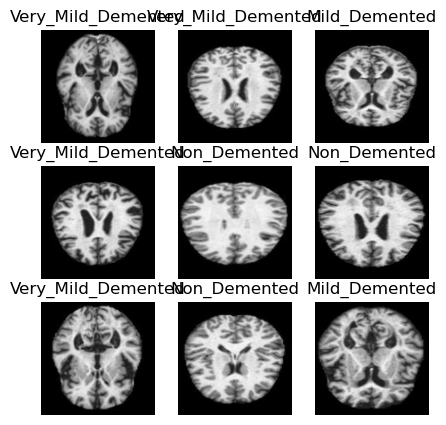

In [34]:
plt.figure(figsize=(5, 5))
for images, labels in train_generator:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")
    break


## Data Augmentation

In [35]:
#preprocessing for rotation and zoom
def data_augmentar():
   
    data_augmentation = Sequential()
    data_augmentation.add(RandomRotation(factor=(-0.15, 0.15)))
    data_augmentation.add(RandomZoom((-0.3, -0.1)))
    
    return data_augmentation

In [36]:
data_augmentation = data_augmentar()
assert(data_augmentation.layers[0].name.startswith('random_rotation'))
assert(data_augmentation.layers[0].factor == (-0.15, 0.15))
assert(data_augmentation.layers[1].name.startswith('random_zoom'))
assert(data_augmentation.layers[1].height_factor == (-0.3, -0.1))

## Solving Imbalanced Data Problem

In [37]:
## Calculate number of samples in each class.
input_folder = '/kaggle/input/alzheimer-mri-dataset/Dataset'
class_counts = dict()
for folder in class_names:
    class_counts[folder] = len(os.listdir(input_folder+'/'+folder))

class_counts

{'Mild_Demented': 896,
 'Moderate_Demented': 64,
 'Non_Demented': 3200,
 'Very_Mild_Demented': 2240}

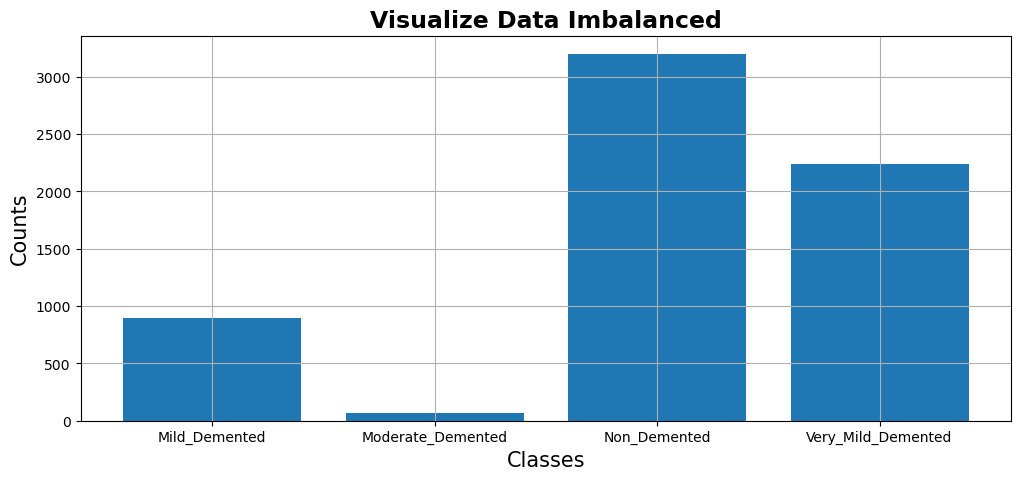

In [38]:
plt.figure(figsize=(12,5))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Classes', fontdict={'fontsize':15})
plt.ylabel('Counts', fontdict={'fontsize':15})
plt.title('Visualize Data Imbalanced', fontdict={'fontsize':17,
                                                 'fontweight':'bold'})
plt.grid(True)
plt.show()

In [39]:
# Class_weight = (Total Number of images/Number of class x Images per class )

total = sum(class_counts.values())
number_of_classes = len([ 'MildDemented',
 'ModerateDemented',
 'NonDemented',
 'VeryMildDemented'])

class_weights = dict()
for i in range(number_of_classes):
    class_weights[i] = round(total / (number_of_classes * list(class_counts.values())[i]), 2)
    print(f'Weight for class \"{class_names[i]}\" : {class_weights[i]}')

Weight for class "Mild_Demented" : 1.79
Weight for class "Moderate_Demented" : 25.0
Weight for class "Non_Demented" : 0.5
Weight for class "Very_Mild_Demented" : 0.71


# **MobileNetV2**

In [40]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load the pre-trained MobileNetV2 model (excluding the top layer)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base model's layers
for layer in base_model.layers:
    layer.trainable = False

# Add a new top layer for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)  # num_classes is the number of your target classes

# Create the final model
model5 = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model5.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy', 
                        tf.keras.metrics.AUC(),
                        tf.keras.metrics.Precision(),
                        tf.keras.metrics.Recall(),
                        ])

# Print the model summary
model5.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_2[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][0]']         

In [41]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [42]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
filepath = './MobileNetV2_best_weigh.hdf5'
# Stop the model when accuracy is not improving
earlystopping = EarlyStopping(monitor = 'val_accuracy', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)
# Finding point where accuracy differs more
checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_accuracy', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

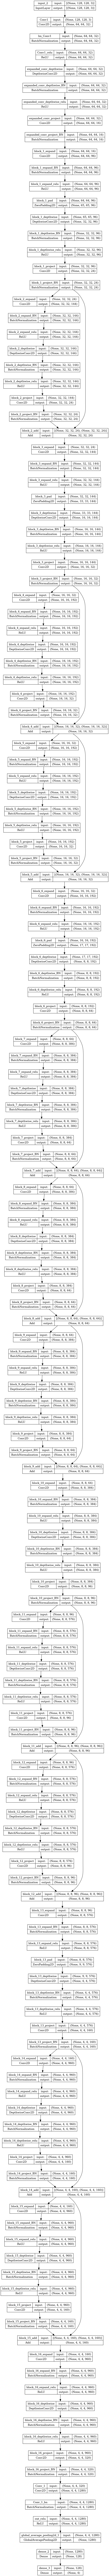

In [43]:
from keras.utils.vis_utils import plot_model
plot_model(model5, to_file='modelEfficinetNet-B7_plot.png', show_shapes=True, show_layer_names=True)

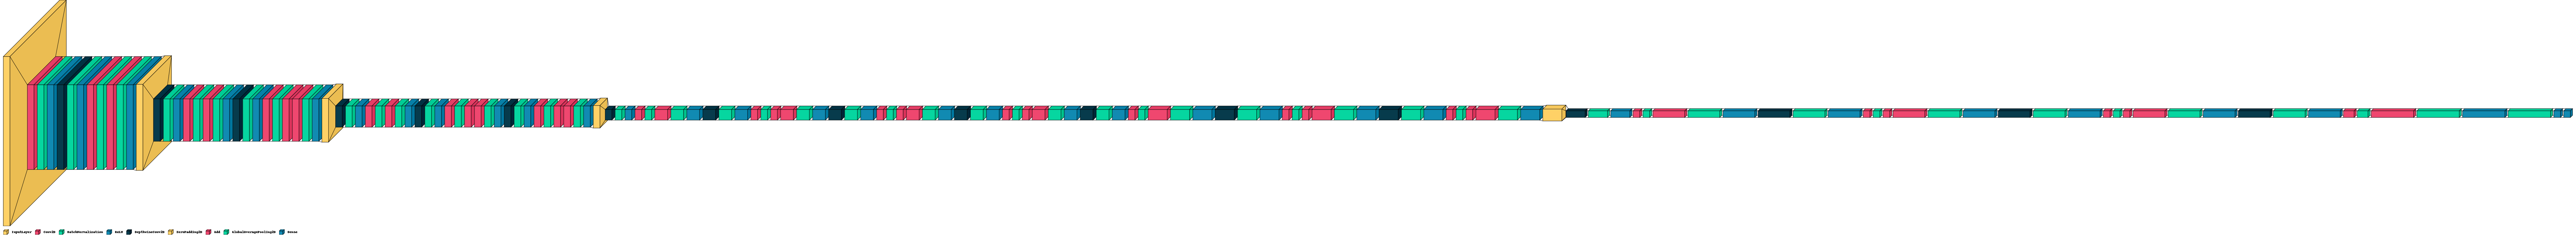

In [44]:
import visualkeras
from PIL import ImageFont
visualkeras.layered_view(model5, legend=True)

In [45]:
history=model5.fit(train_generator,
                        validation_data=validation_generator,
                        steps_per_epoch=len(train_generator)//32,
                        epochs = 50,callbacks = callback_list,
                        verbose = 1,batch_size=32)

Epoch 1/50
2/2 [==============================] - ETA: 0s - loss: 1.7234 - accuracy: 0.4141 - auc: 0.5906 - precision: 0.4113 - recall: 0.3984
Epoch 1: val_accuracy improved from -inf to 0.50078, saving model to ./MobileNetV2_best_weigh.hdf5
2/2 [==============================] - 10s 6s/step - loss: 1.7234 - accuracy: 0.4141 - auc: 0.5906 - precision: 0.4113 - recall: 0.3984 - val_loss: 1.5964 - val_accuracy: 0.5008 - val_auc: 0.7273 - val_precision: 0.5008 - val_recall: 0.5008
Epoch 2/50
2/2 [==============================] - ETA: 0s - loss: 1.5799 - accuracy: 0.4609 - auc: 0.7184 - precision: 0.4609 - recall: 0.4609
Epoch 2: val_accuracy did not improve from 0.50078
2/2 [==============================] - 6s 6s/step - loss: 1.5799 - accuracy: 0.4609 - auc: 0.7184 - precision: 0.4609 - recall: 0.4609 - val_loss: 1.2586 - val_accuracy: 0.3975 - val_auc: 0.6975 - val_precision: 0.4099 - val_recall: 0.2598
Epoch 3/50
2/2 [==============================] - ETA: 0s - loss: 1.2079 - accuracy

In [46]:
model5.evaluate(test_generator)

11/11 [==============================] - 4s 363ms/step - loss: 0.9412 - accuracy: 0.5810 - auc: 0.8420 - precision: 0.6200 - recall: 0.4829


[0.9411566853523254,
 0.5809968709945679,
 0.8419889211654663,
 0.6200000047683716,
 0.4828660488128662]

In [47]:
#result3 = model5.evaluate(train_generator)
#test_loss = result3[0]
#test_accuracy = result3[1]
#test_AUC = result3[2]
#test_pre = result3[3]
#test_rec = result3[4]
#print(f'Train Loss = {test_loss}')
#print(f'Train Accuracy = {test_accuracy}')
#print(f'Train AUC = {test_AUC}')
#print(f'Train Precision = {test_pre}')
#print(f'Train Recall = {test_rec}')
#acc.append(test_accuracy*100)

In [49]:
result = model5.evaluate(test_generator)
test_loss = result[0]
test_accuracy = result[1]
test_AUC = result[2]
test_pre = result[3]
test_rec = result[4]
print(f'Test Loss = {test_loss}')
print(f'Test Accuracy = {test_accuracy}')
print(f'Test AUC = {test_AUC}')
print(f'Test Precision = {test_pre}')
print(f'Test Recall = {test_rec}')


11/11 [==============================] - 4s 367ms/step - loss: 0.9412 - accuracy: 0.5810 - auc: 0.8420 - precision: 0.6200 - recall: 0.4829
Test Loss = 0.941156804561615
Test Accuracy = 0.5809968709945679
Test AUC = 0.8419889211654663
Test Precision = 0.6200000047683716
Test Recall = 0.4828660488128662


# **Plotting Results**

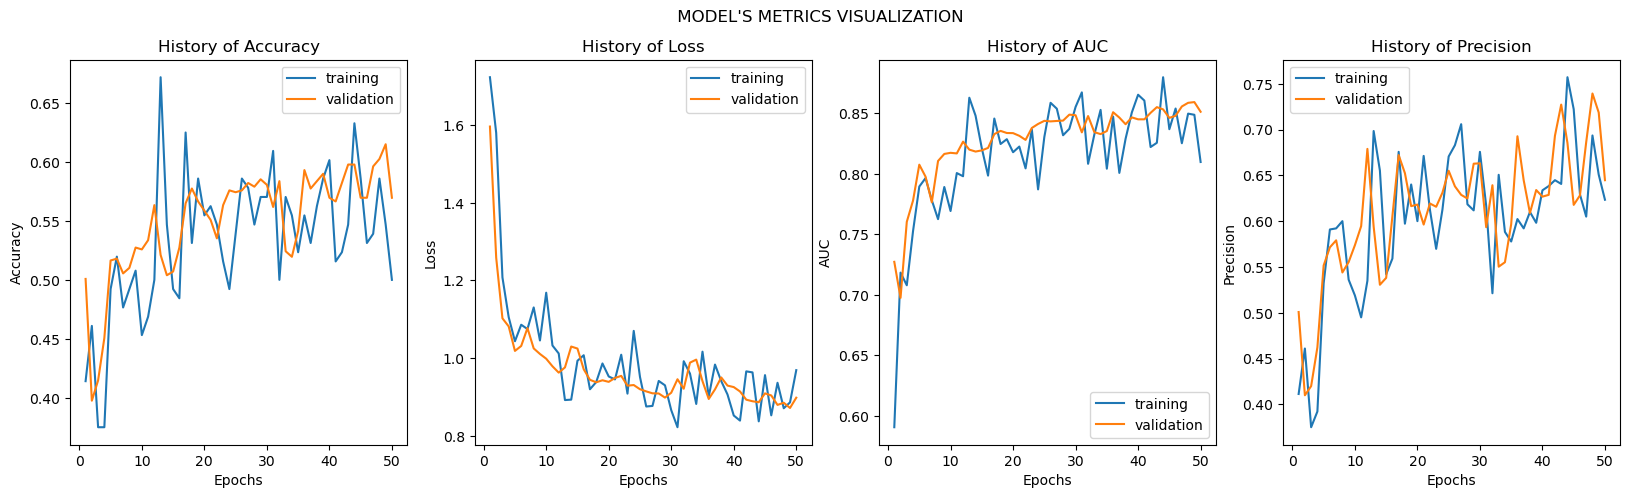

In [53]:
def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision):
    
    fig, (ax1, ax2,ax3,ax4) = plt.subplots(1,4, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
  


    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision']
              
              )

In [51]:
# Generate predictions
train_predictions = model5.predict(train_generator)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_generator.classes

validation_predictions = model5.predict(validation_generator)
validation_predicted_labels = np.argmax(validation_predictions, axis=1)
validation_true_labels = validation_generator.classes

test_predictions = model5.predict(test_generator)
test_predicted_labels = np.argmax(test_predictions, axis=1)
test_true_labels = test_generator.classes

# Calculate confusion matrices
train_cm = confusion_matrix(train_true_labels, train_predicted_labels)
validation_cm = confusion_matrix(validation_true_labels, validation_predicted_labels)
test_cm = confusion_matrix(test_true_labels, test_predicted_labels)

# Define class labels (modify based on your specific problem)
class_labels = ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']

11/11 [==============================] - 4s 356ms/step


In [52]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# **Confusion Matrix**

Confusion matrix, without normalization


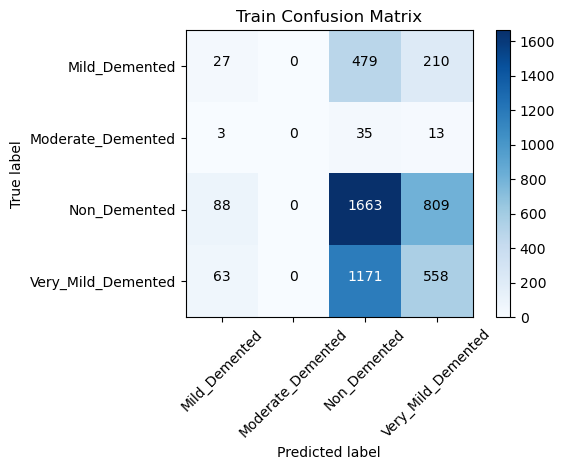

Confusion matrix, without normalization


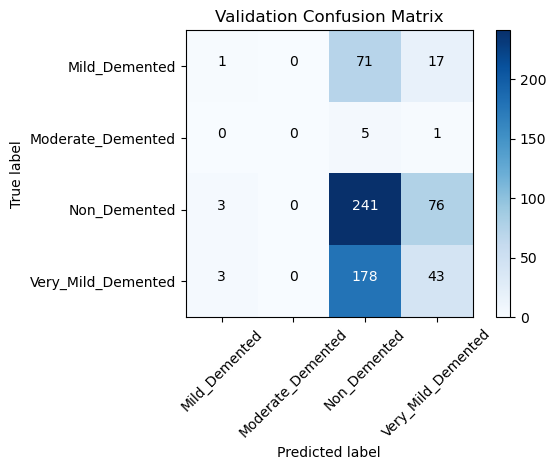

Confusion matrix, without normalization


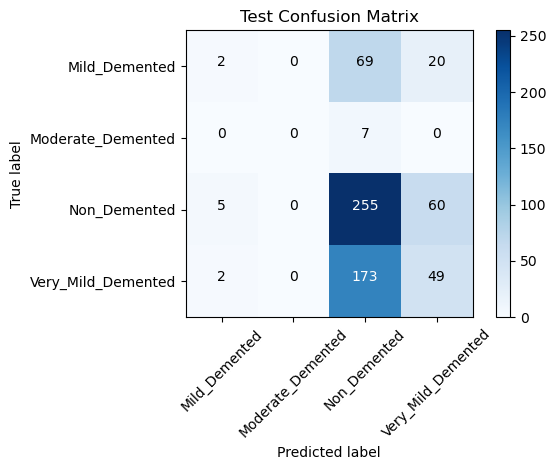

In [54]:
import itertools
# Calculate confusion matrices
train_cm = confusion_matrix(train_true_labels, train_predicted_labels)
validation_cm = confusion_matrix(validation_true_labels, validation_predicted_labels)
test_cm = confusion_matrix(test_true_labels, test_predicted_labels)

# Define class labels (modify based on your specific problem)
class_labels = ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']

# Plot confusion matrices
plot_confusion_matrix(train_cm, classes=class_labels, title='Train Confusion Matrix')
plt.show()

plot_confusion_matrix(validation_cm, classes=class_labels, title='Validation Confusion Matrix')
plt.show()

plot_confusion_matrix(test_cm, classes=class_labels, title='Test Confusion Matrix')
plt.show()